In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ants
import nibabel as nib
from time import time
from xml.etree import ElementTree as ET
import os
import pandas as pd
import sys
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
from scipy import signal
from scipy.ndimage import zoom

sys.path.insert(0, '/home/users/brezovec/projects/lysis/')
from bruker import *

%matplotlib inline

In [362]:
def load_brain(file):
    try:
        brain = nib.load(file).get_data()
        brain = np.swapaxes(brain, 0, 1)
        brain = np.squeeze(brain)
        brain = ants.from_numpy(brain)
    except:
        brain = None
    return brain

def rotate_brain(brain):
    try:
        if type(brain) is not np.ndarray:
            brain = brain.numpy()
        brain = np.swapaxes(brain, 0, 1)
        brain = ants.from_numpy(brain)
    except:
        brain = None
    return brain

def remove_empty_axes(brain):
    if type(brain) is not np.ndarray:
        brain = brain.numpy()
    brain = np.squeeze(brain)
    brain = ants.from_numpy(brain)
    return brain

def load_brains_from_dir(folder):
    brain_files = sorted(os.listdir(folder))
    full_brain_files = [folder+brain_file for brain_file in brain_files]
    brains = [load_brain(brain) for brain in full_brain_files]
    return brains

def set_resolution(brain, xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    statevalues = root.findall('PVStateShard')[0].findall('PVStateValue')
    for statevalue in statevalues:
        key = statevalue.get('key')
        if key == 'micronsPerPixel':
            indices = statevalue.findall('IndexedValue')
            for index in indices:
                axis = index.get('index')
                if axis == 'XAxis':
                    x = float(index.get('value'))
                elif axis == 'YAxis':
                    y = float(index.get('value'))
                elif axis == 'ZAxis':
                    z = float(index.get('value'))
                else:
                    print('Error')
    try:
        brain.set_spacing([x,y,z])
    except:
        pass

# Create first pass mean-brain

### Load anatomical scans

In [3]:
folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/'
brains = load_brains_from_dir(folder)

### Create fly objects

In [315]:
class Fly:
    def __init__(self):
        pass

In [316]:
flies = [Fly() for i in range(len(brains))]

### Assign Brains

In [390]:
for i in range(len(brains)):
    flies[i].anatomy = brains[i]

### Set correct resolution

In [392]:
xml_folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/anatomy_xml/'
xml_files = sorted(os.listdir(xml_folder))
full_xml_files = [xml_folder+xml_file for xml_file in xml_files]
for i, fly in enumerate(flies):
    set_resolution(fly.anatomy, full_xml_files[i])

### Rotate brains if needed

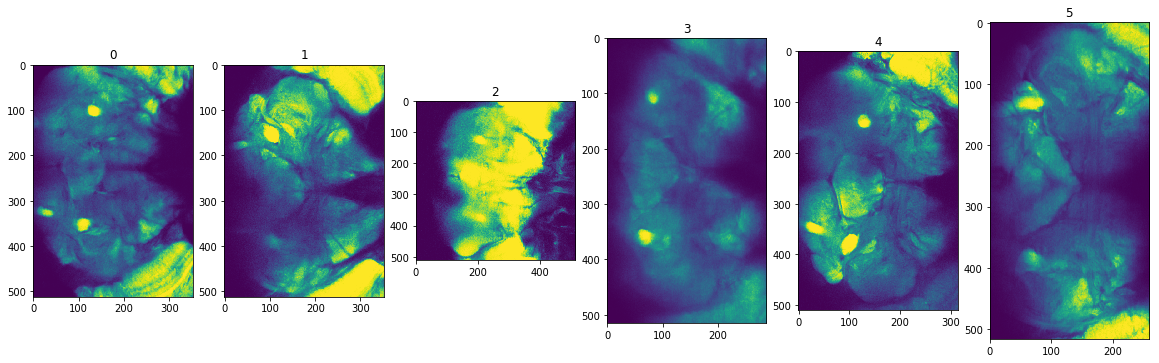

In [393]:
fig = plt.figure(figsize=[20,20])
for i in range(len(flies)):
    plt.subplot(1,6,i+1)
    plt.imshow(flies[i].anatomy[:,:,100])
    plt.title(i)

In [129]:
brains_to_rotate = [5]
for i in brains_to_rotate:
    flies[i].brain = rotate_brain(flies[i].anatomy)

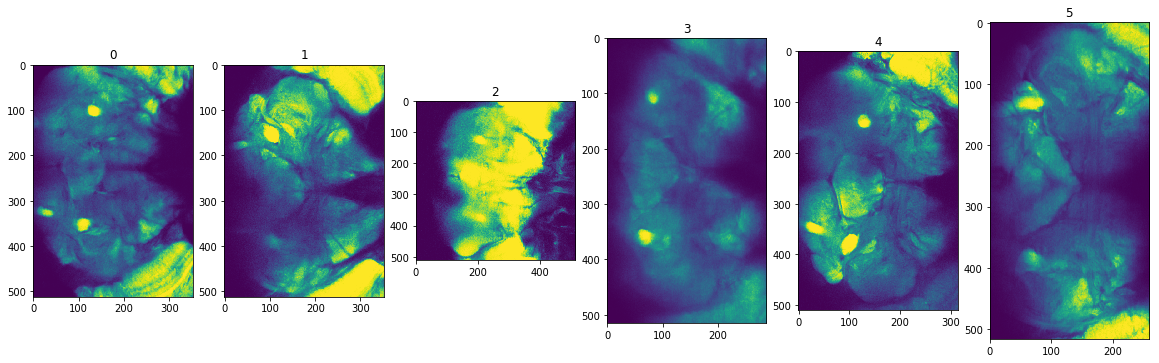

In [707]:
fig = plt.figure(figsize=[20,20])
for i in range(len(flies)):
    plt.subplot(1,6,i+1)
    plt.imshow(flies[i].anatomy[:,:,100])
    plt.title(i)

### Pick index of reference brain to align to

In [132]:
ref_brain = 0

### Downsample brains

In [323]:
for fly in flies:
    fly.anatomy_d = ants.resample_image(fly.anatomy, [4,4,4])

### Warp downsampled-brains to reference

In [326]:
for i, fly in enumerate(flies):
    t0 = time()
    motCorr = ants.registration(flies[ref_brain].anatomy_d,
                                fly.anatomy_d,
                                type_of_transform='SyNCC')
    fly.warp_anat_to_mean = motCorr
    print(time()-t0)

60.198984146118164
100.79969477653503
103.47925090789795
82.07350659370422
165.56360411643982
93.00505113601685


### How do they look?

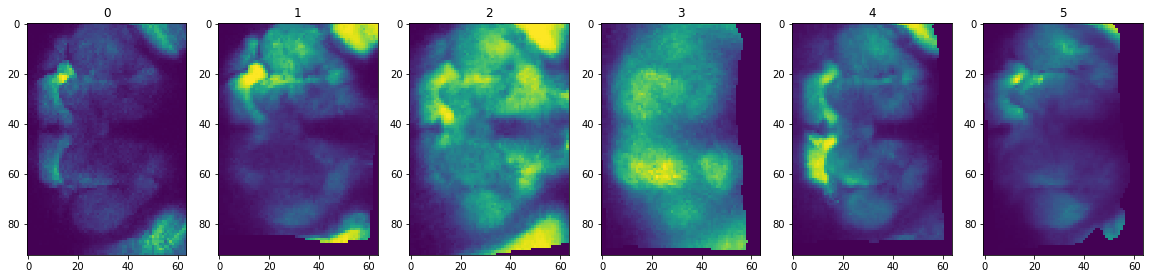

In [329]:
fig = plt.figure(figsize=[20,20])
for i in range(len(flies)):
    plt.subplot(1,6,i+1)
    plt.imshow(flies[i].warp_anat_to_mean['warpedmovout'][:,:,40])
    plt.title(i)

### Apply warp parameters to full resolution anatomy brains

In [330]:
for i, fly in enumerate(flies):
    t0 = time()
    warp = ants.apply_transforms(flies[ref_brain].anatomy,
                                 fly.anatomy,
                                 fly.warp_anat_to_mean['fwdtransforms'])
    fly.anatomy_warped_to_mean = warp
    print(time()-t0)

1.857327938079834
1.7992026805877686
2.0672903060913086
1.629331350326538
1.7221527099609375
1.6622400283813477


### How do they look?

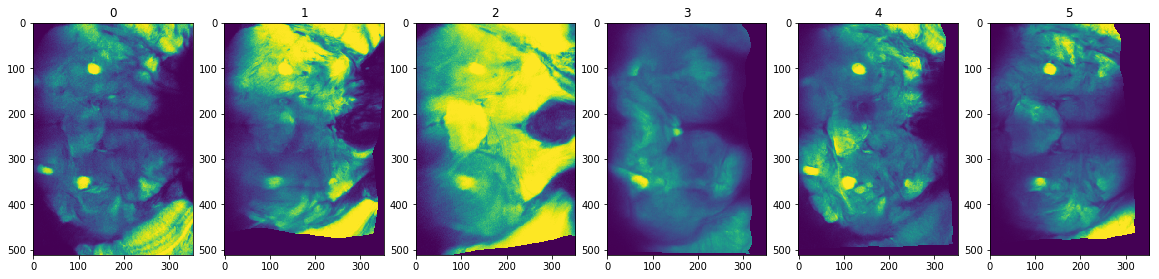

In [708]:
fig = plt.figure(figsize=[20,20])
for i in range(len(flies)):
    plt.subplot(1,6,i+1)
    plt.imshow(flies[i].anatomy_warped_to_mean[:,:,100])
    plt.title(i)

### Save warped anatomical brains

In [333]:
folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/warped_anatomy'

for i, fly in enumerate(flies):
    save_file = os.path.join(folder, 'brain_' + str(i+1) + '.nii')
    ants.image_write(fly.anatomy_warped_to_mean, save_file)

### Use Fiji to check which brains aligned well

In [334]:
good_anatomy_alignment = [0,1,2,4,5]

### Average these aligned brains to create a first-pass meanbrain

In [335]:
test_brains = [flies[i].anatomy_warped_to_mean.numpy() for i in good_anatomy_alignment]
mean_brain = np.mean(np.array(test_brains), axis = 0)

Text(0.5, 1.0, 'Mean-brain, first pass')

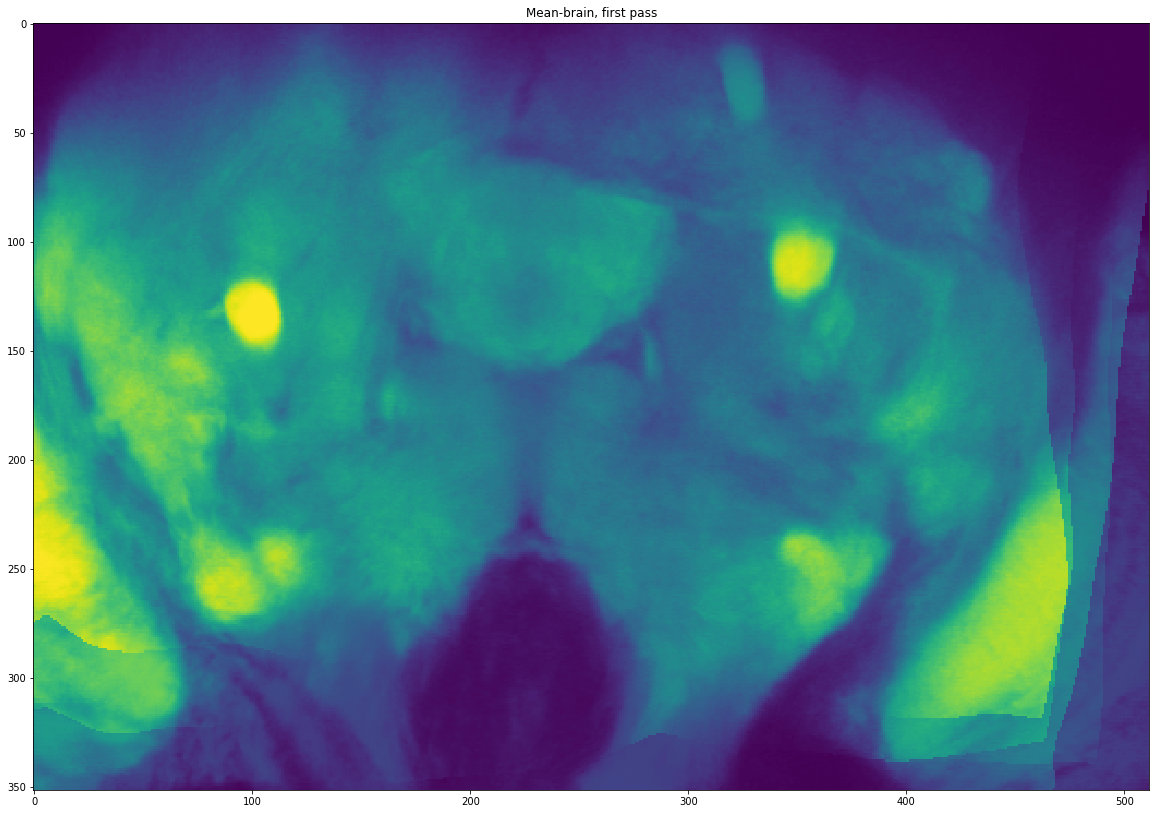

In [342]:
fig = plt.figure(figsize=[20,20])
plt.imshow(np.swapaxes(mean_brain[:,:,100],0,1))
plt.title('Mean-brain, first pass')

In [337]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/warped_anatomy/meanbrain.nii'
ants.image_write(ants.from_numpy(mean_brain), save_file)

# Make second-pass mean-brain

### Do this step once I have a nicer looking brain to initialize the process with

# Align functional data to their respective anatomy

### Load functional data

In [343]:
folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains_functional/'
brains_functional = load_brains_from_dir(folder)

### Create means of functional data

In [344]:
functional_means = []
for i, brain in enumerate(brains_functional):
    print(i)
    try:
        functional_means.append(brain.mean(3))
    except:
        functional_means.append(None)

0
1
2
3
4
5


### Assign functional brains to flies

In [371]:
for i, fly in enumerate(flies):
    try:
        fly.functional = ants.from_numpy(functional_means[i])
    except:
        pass

### How do they look?

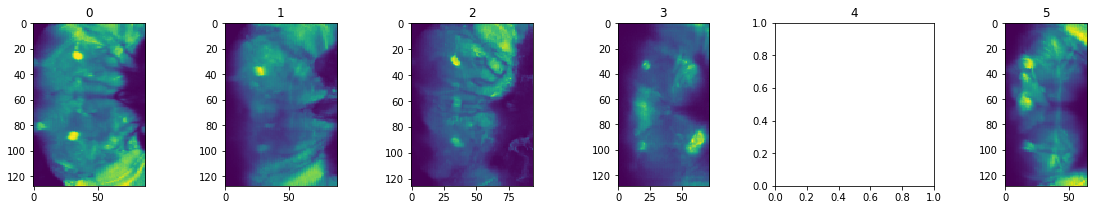

In [394]:
fig = plt.figure(figsize=[20,3])
for i, fly in enumerate(flies):
    plt.subplot(1,6,i+1)
    try:
        plt.imshow(fly.functional[:,:,20])
    except:
        pass
    plt.title(i)

### Rotate functional if needed

In [376]:
brains_to_rotate = [0,1,2,3,4,5]
for i in brains_to_rotate:
    flies[i].functional = rotate_brain(flies[i].functional)

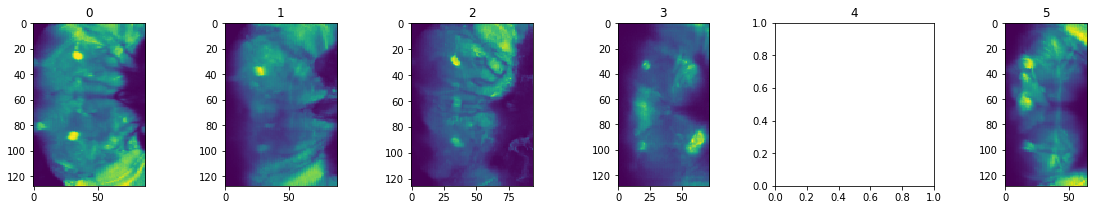

In [657]:
fig = plt.figure(figsize=[20,3])
for i, fly in enumerate(flies):
    plt.subplot(1,6,i+1)
    try:
        plt.imshow(fly.functional[:,:,20])
    except:
        pass
    plt.title(i)

### Set correct resolution

In [395]:
xml_folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/functional_xml/'
xml_files = sorted(os.listdir(xml_folder))
full_xml_files = [xml_folder+xml_file for xml_file in xml_files]
for i, fly in enumerate(flies):
    set_resolution(fly.functional, full_xml_files[i])

### Align functional to anatomy (Affine)

In [677]:
for fly in flies:
    t0 = time()
    try:
        fly.func2anat = ants.registration(fly.anatomy,
                        fly.functional,
                        type_of_transform='Affine')
    except:
        fly.func2anat = None
    print(time()-t0)

139.2754442691803
96.28054881095886
180.91674661636353
52.01777625083923
0.2809607982635498
62.614025592803955


### How do they look?

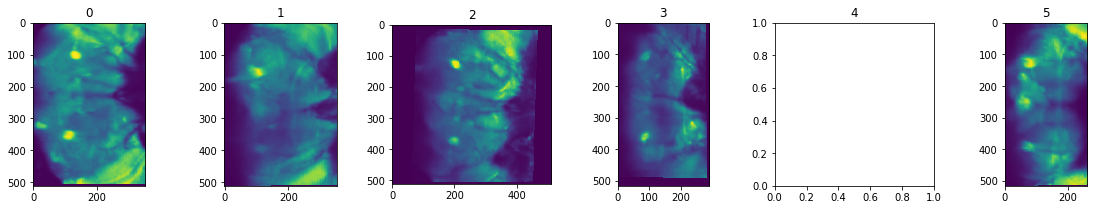

In [678]:
fig = plt.figure(figsize=[20,3])
for i, fly in enumerate(flies):
    plt.subplot(1,6,i+1)
    try:
        plt.imshow(fly.func2anat['warpedmovout'][:,:,100])
    except:
        pass
    plt.title(i)

# Load standard brain template and align my meanbrain to it

### Load template

In [408]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/JFRCtemplate2010.nii'
template = load_brain(file)

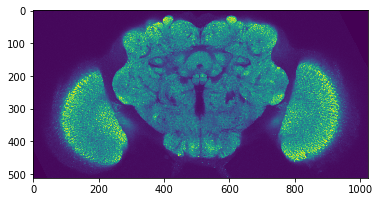

In [653]:
plt.imshow(template[:,:,100])

### Get mean brain into correct orientation and set spacing

In [413]:
mean_brain = rotate_brain(mean_brain)
mean_brain = np.flip(mean_brain.numpy(), 2)
mean_brain = ants.from_numpy(mean_brain)
mean_brain.set_spacing([0.725325831346074, 0.725325831346074, 1])
template.set_spacing([0.62, 0.62, 0.62])

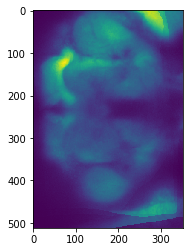

In [723]:
plt.imshow(mean_brain[:,:,100])

### Align meanbrain to template

In [655]:
t0 = time()
warped_mean = ants.registration(template,
                                mean_brain,
                                type_of_transform='SyN')
print(time()-t0)

690.2214901447296


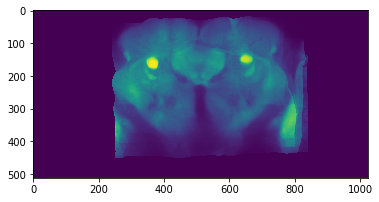

In [656]:
plt.imshow(warped_mean['warpedmovout'][:,:,100])

# Align functional data to final template

### Need to apply two transforms. 1) anat2mean 2) mean2template. Be sure to flip z-axis between tranforms

### First, apply anat2mean transform to functional

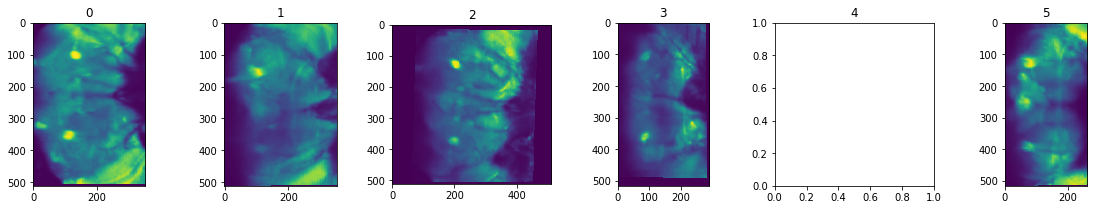

In [731]:
fig = plt.figure(figsize=[20,3])
for i, fly in enumerate(flies):
    plt.subplot(1,6,i+1)
    try:
        plt.imshow(fly.func2anat['warpedmovout'][:,:,100])
    except:
        pass
    plt.title(i)

In [717]:
for fly in flies:
    t0 = time()
    try:
        fly.func2anatmean = ants.apply_transforms(mean_brain,
                                                  fly.func2anat['warpedmovout'],
                                                  fly.warp_anat_to_mean['fwdtransforms'])
    except:
        fly.func2anatmean = None
    print(time()-t0)

1.9525163173675537
1.7964699268341064
2.3786606788635254
1.8123855590820312
1.9550323486328125e-05
1.7357556819915771


### How do they look?

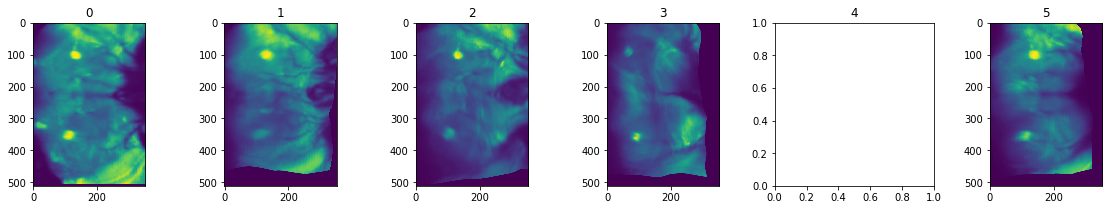

In [730]:
fig = plt.figure(figsize=[20,3])
for i, fly in enumerate(flies):
    plt.subplot(1,6,i+1)
    try:
        plt.imshow(fly.func2anatmean[:,:,100])
    except:
        pass
    plt.title(i)

##### Looks good, remember that brain 4 (index 3), didn't align anat well

### Flip in z

In [739]:
for fly in flies:
    try:
        temp = np.flip(fly.func2anatmean.numpy(), 2)
        fly.func2anatmean = ants.from_numpy(temp)
    except:
        pass

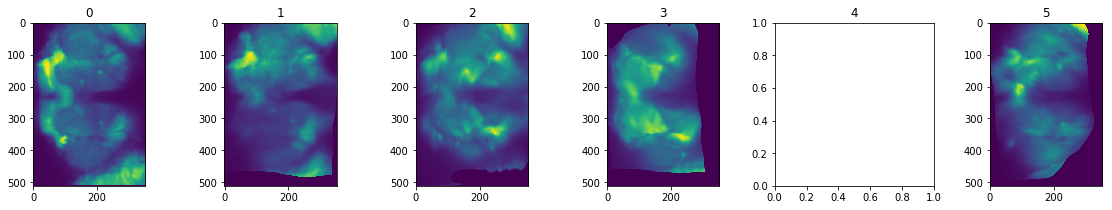

In [740]:
fig = plt.figure(figsize=[20,3])
for i, fly in enumerate(flies):
    plt.subplot(1,6,i+1)
    try:
        plt.imshow(fly.func2anatmean[:,:,100])
    except:
        pass
    plt.title(i)

### Apply mean2template transform

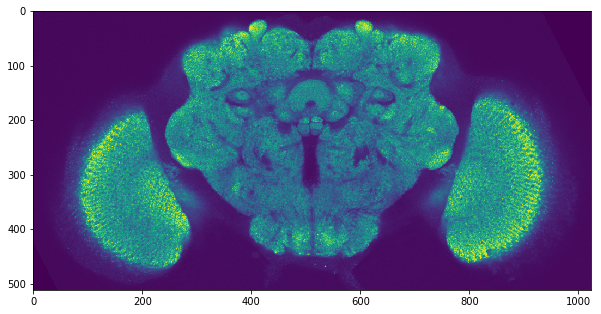

In [764]:
fig = plt.figure(figsize=[10,10])
plt.imshow(template[:,:,100])

In [763]:
template = rotate_brain(template)

In [770]:
template.set_spacing([0.62, 0.62, 0.62])

In [776]:
mean_brain

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (512, 352, 267)
	 Spacing    : (0.725325831346074, 0.725325831346074, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [777]:
for fly in flies:
    try:
        fly.func2anatmean.set_spacing([0.725325831346074, 0.725325831346074, 1.0])
    except:
        pass

In [765]:
for fly in flies:
    try:
        fly.func2anatmean = rotate_brain(fly.func2anatmean)
    except:
        pass

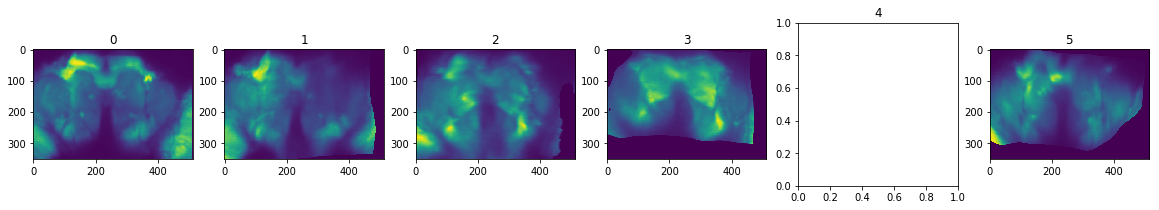

In [778]:
fig = plt.figure(figsize=[20,3])
for i, fly in enumerate(flies):
    plt.subplot(1,6,i+1)
    try:
        plt.imshow(fly.func2anatmean[:,:,100])
    except:
        pass
    plt.title(i)

In [779]:
for fly in flies:
    t0 = time()
    try:
        fly.func2template = ants.apply_transforms(template,
                                                  fly.func2anatmean,
                                                  warped_mean['fwdtransforms'])
    except:
        fly.func2template = None
    print(time()-t0)

17.47341823577881
17.501304864883423
17.980697631835938
17.47046732902527
4.601478576660156e-05
18.054726123809814


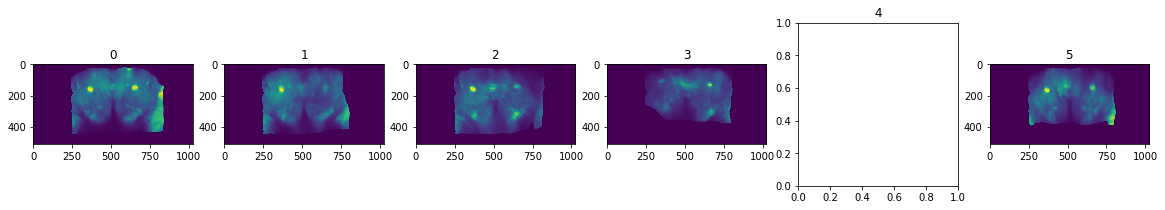

In [780]:
fig = plt.figure(figsize=[20,3])
for i, fly in enumerate(flies):
    plt.subplot(1,6,i+1)
    try:
        plt.imshow(fly.func2template[:,:,100])
    except:
        pass
    plt.title(i)

### Save func2template

In [782]:
folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/func_to_template'

for i, fly in enumerate(flies):
    try:
        save_file = os.path.join(folder, 'brain_' + str(i+1) + '.nii')
        ants.image_write(fly.func2template, save_file)
    except:
        pass

In [737]:
temp = np.flip(flies[5].func2anatmean.numpy(), 2)
flies[5].func2anatmean = ants.from_numpy(temp)

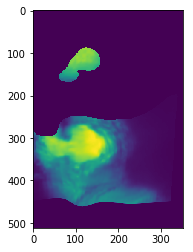

In [729]:
plt.imshow(flies[1].func2anatmean[:,:,30])

In [ ]:
fly.warp_anat_to_mean['fwdtransforms']

In [699]:
test = ants.apply_transforms(mean_brain,
                            flies[0].func2anat['warpedmovout'],
                            flies[0].warp_anat_to_mean['fwdtransforms'])

In [672]:
plt.imshow(flies[0].func2anatmean[:,:,10])

AttributeError: 'Fly' object has no attribute 'func2anatmean'

In [ ]:
fly.warp_anat_to_mean['fwdtransforms']
warped_mean['fwdtransforms']

In [ ]:
for fly in flies:
    t0 = time()
    try:
        fly.func2anat = ants.apply_transform(warped_mean,
                        fly.func2anat,
                        type_of_transform='Affine')
    except:
        fly.func2anat = None
    print(time()-t0)

In [430]:
template_d = ants.resample_image(template, [4,4,4])

In [431]:
meanbrain_d = ants.resample_image(mean_brain, [4,4,4])

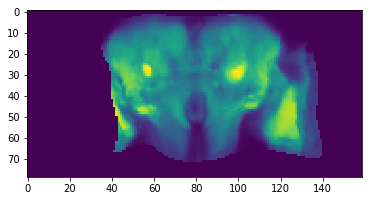

In [444]:
plt.imshow(warped_mean['warpedmovout'][:,:,20])

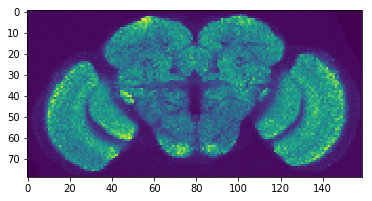

In [437]:
plt.imshow(template_d[:,:,20])

### Apply warp parameters to full resolution files

In [445]:
t0 = time()
meanbrain_to_template = ants.apply_transforms(template,
                                              mean_brain,
                                              warped_mean['fwdtransforms'])
print(time()-t0)

3.4170684814453125


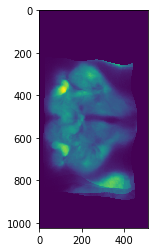

In [448]:
plt.imshow(meanbrain_to_template[:,:,80])

In [446]:
meanbrain_to_template = rotate_brain(meanbrain_to_template)

In [453]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/temp_mean.nii'
ants.image_write(mean_brain, save_file)

In [455]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/low_contrast_mean.nii'
low_contrast_mean = load_brain(file)

In [457]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/kevin_meanbrain.nii'
kevin_mean = load_brain(file)

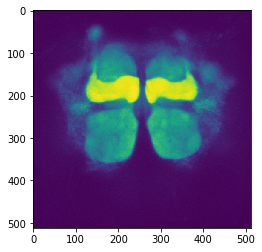

In [459]:
plt.imshow(kevin_mean[:,:,30])

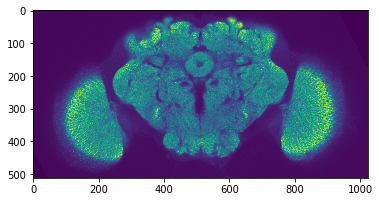

In [493]:
plt.imshow(template[:,:,90])

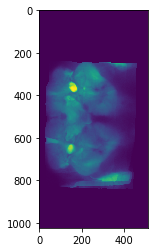

In [501]:
plt.imshow(warp2template_synfull['warpedmovout'][:,:,90])

In [480]:
t0 = time()
warped_to_kevin_syn_full = ants.registration(kevin_mean,
                                mean_brain,
                                type_of_transform='SyN')
print(time()-t0)

741.4370794296265


In [486]:
warped_to_kevin_syn_full

{'fwdtransforms': ['/tmp/tmpe7gpgw2c1Warp.nii.gz',
  '/tmp/tmpe7gpgw2c0GenericAffine.mat'],
 'invtransforms': ['/tmp/tmpe7gpgw2c0GenericAffine.mat',
  '/tmp/tmpe7gpgw2c1InverseWarp.nii.gz'],
 'warpedfixout': ANTsImage
 	 Pixel Type : float
 	 Components : 1
 	 Dimensions : (352, 512, 267)
 	 Spacing    : (0.725325831346074, 0.725325831346074, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'warpedmovout': ANTsImage
 	 Pixel Type : float
 	 Components : 1
 	 Dimensions : (512, 512, 264)
 	 Spacing    : (0.65, 0.65, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]}

In [489]:
t0 = time()
warp2template_synfull = ants.registration(template,
                                          mean_brain,
                                          type_of_transform='SyN')
print(time()-t0)

664.9418430328369


In [536]:
flies[0].anatomy_flip = rotate_brain(flies[0].anatomy_flip)

In [465]:
meanbrain_d

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (64, 93, 67)
	 Spacing    : (4.0, 4.0, 4.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [467]:
kevin_mean.set_spacing([0.65,0.65,1])

In [468]:
kevin_mean_d = ants.resample_image(kevin_mean, [4,4,4])

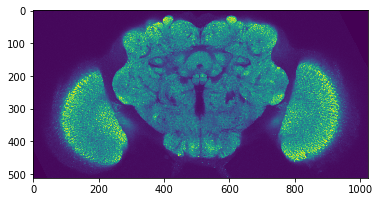

In [534]:
plt.imshow(template[:,:,100])

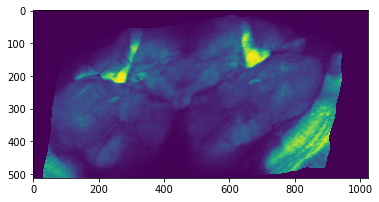

In [540]:
plt.imshow(anat2template_syn_2nd['warpedmovout'][:,:,100])

In [531]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/anat2template_syn.nii'
ants.image_write(anat2template_syn['warpedmovout'], save_file)

### Try warping anatomy files to new meanbrain aligned to template

In [510]:
flies[0].anatomy_flip = np.flip(flies[0].anatomy.numpy(), 2)

In [511]:
flies[0].anatomy_flip = ants.from_numpy(flies[0].anatomy_flip)

In [538]:
t0 = time()
anat2template_syn_2nd = ants.registration(template,
                                      flies[0].anatomy_flip,
                                      type_of_transform='SyN')
print(time()-t0)

662.4971270561218


### Try downsampling single anatomy and template and aligning this way

In [541]:
testbrain_d = ants.resample_image(flies[0].anatomy_flip, [4,4,4])

In [542]:
template_d = ants.resample_image(template, [4,4,4])

In [560]:
kevin_mean_d = ants.resample_image(kevin_mean, [4,4,4])

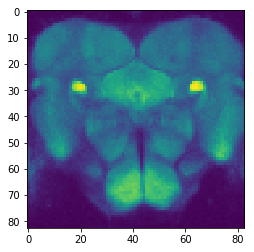

In [567]:
plt.imshow(kevin_mean_d[:,:,30])

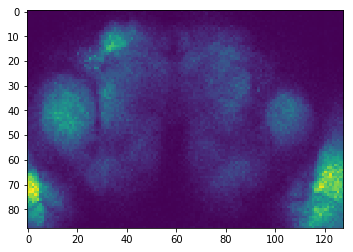

In [543]:
plt.imshow(testbrain_d[:,:,30])

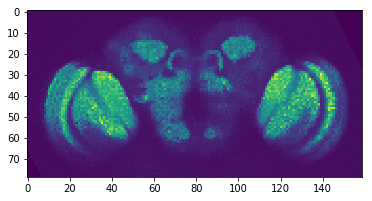

In [643]:
plt.imshow(template_d[:,:,28])

5.021671772003174


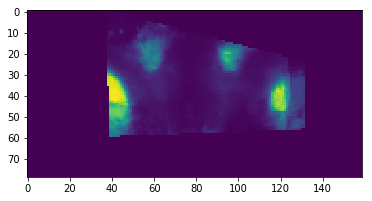

In [652]:
t0 = time()
test = ants.registration(template_d,
                         meanbrain_d,
                         type_of_transform='SyNRA',
                         grad_step=1,
                         flow_sigma=10,
                         total_sigma=1,
                         aff_metric='GC',
                         syn_sampling=64,
                         aff_sampling=32,
                         syn_metric='GC')
print(time()-t0)
plt.imshow(test['warpedmovout'][:,:,28])

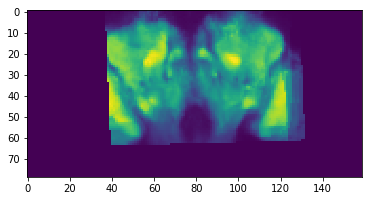

In [649]:
plt.imshow(test['warpedmovout'][:,:,23])

In [588]:
help(ants.registration)

Help on function registration in module ants.registration.interface:

registration(fixed, moving, type_of_transform='SyN', initial_transform=None, outprefix='', mask=None, grad_step=0.2, flow_sigma=3, total_sigma=0, aff_metric='mattes', aff_sampling=32, syn_metric='mattes', syn_sampling=32, reg_iterations=(40, 20, 0), verbose=False, **kwargs)
    Register a pair of images either through the full or simplified 
    interface to the ANTs registration method.
    
    ANTsR function: `antsRegistration`
    
    Arguments
    ---------
    fixed : ANTsImage
        fixed image to which we register the moving image.
    
    moving : ANTsImage
        moving image to be mapped to fixed space.
    
    type_of_transform : string
        A linear or non-linear registration type. Mutual information metric by default. 
        See Notes below for more.
    
    initial_transform : list of strings (optional)  
        transforms to prepend
    
    outprefix : string
        output will be named

In [634]:
t0 = time()
meanbrain_to_template = ants.apply_transforms(template,
                                              mean_brain,
                                              test['fwdtransforms'])
print(time()-t0)

3.808242082595825


In [639]:
meanbrain_to_template = rotate_brain(meanbrain_to_template)

In [640]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/meanbrain_to_template1222.nii'
ants.image_write(meanbrain_to_template, save_file)

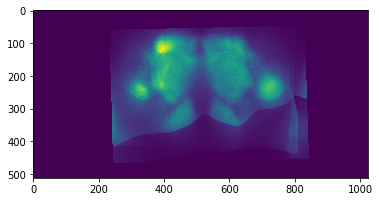

In [637]:
plt.imshow(meanbrain_to_template[:,:,50])

In [564]:
kevin_mean_d

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (83, 83, 66)
	 Spacing    : (4.0, 4.0, 4.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [565]:
anat2template_syn_down['warpedmovout']

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (83, 83, 66)
	 Spacing    : (4.0, 4.0, 4.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

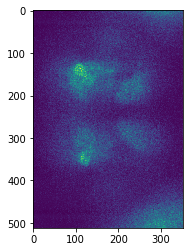

In [521]:
plt.imshow(flies[0].anatomy_flip[:,:,20])

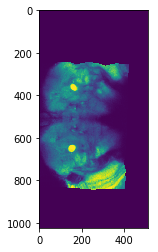

In [513]:
plt.imshow(anat2meanbrain0template_syn['warpedmovout'][:,:,130])

In [508]:
flies[0].anatomy

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (512, 352, 267)
	 Spacing    : (0.725325831346074, 0.725325831346074, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [436]:
template_d 

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (79, 159, 34)
	 Spacing    : (4.0, 4.0, 4.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

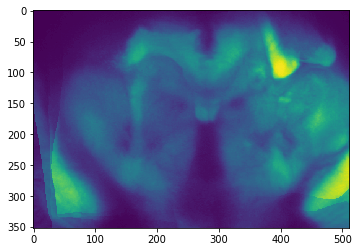

In [456]:
plt.imshow(low_contrast_mean[:,:,120])

In [398]:
func_aligned = ants.registration(flies[0].anatomy,
               flies[0].functional,
               type_of_transform='Affine')

In [249]:
brains_d[0]

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (88, 128, 67)
	 Spacing    : (4.0, 4.0, 4.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [ ]:
brain_files = ['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181127/fly1/TSeries-11272018-1436-000.nii',
               '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181214/fly1/TSeries-12142018-1527-001.nii',
               '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181214/fly2/TSeries-12142018-1527-000.nii',
               '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly1/TSeries-12172018-1322-000.nii',
               '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly2/TSeries-12172018-1322-001_green.nii']

In [3]:
brain_folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains'
brain_files_suf = ['brain_1.nii', 'brain_2.nii', 'brain_3.nii', 'brain_4.nii', 'brain_5.nii', 'brain_6.nii']

In [3]:
folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/'
brains = load_brains_from_dir(folder)

In [4]:
test = load_brain('/tmp/tmp3y_1i7my1Warp.nii.gz')

In [6]:
brains[0] = rotate_brain(brains[0])
brains[1] = rotate_brain(brains[1])

In [48]:
test

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (88, 128, 67, 3)
	 Spacing    : (1.0, 1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

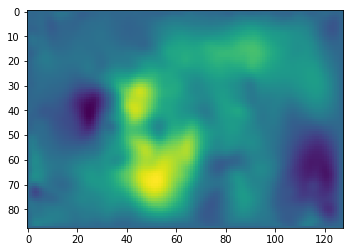

In [5]:
plt.imshow(test[:,:,50,0])

In [4]:
brain_files = [os.path.join(brain_folder, brain) for brain in brain_files_suf]

In [5]:
brain_files

['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_1.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_2.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_3.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_4.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_5.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brains/brain_6.nii']

In [5]:
brains = []

for i, brain_file in enumerate(brain_files):
    print("loading brain", i+1)
    brain = load_brain(brain_file)
    brains.append(brain)

loading brain 1
loading brain 2
loading brain 3
loading brain 4
loading brain 5
loading brain 6


In [7]:
brain_down = []

for brain in brains:
    down = downsample_brain(brain, 0.25)
    brain_down.append(down)

/home/users/brezovec/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning:

From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.



In [8]:
meanbrains = []

for i, brain in enumerate(brains):
    print("averaging brain", i+1)
    meanbrain = brain.mean(3)
    meanbrain = ants.from_numpy(meanbrain)
    meanbrains.append(meanbrain)

averaging brain 1


In [59]:
warps = []

for brain in brains_tidy:
    t0 = time()
    motCorr = ants.registration(brains_tidy[0],
                                brain,
                                type_of_transform='SyNCC',
                                grad_step = 0.2,
                                flow_sigma=3,
                                total_sigma=0)
    print(time()-t0)
    warped = motCorr['warpedmovout'].numpy()
    warps.append(warped)
    #warped_fixed = motCorr['warpedfixout'].numpy()

104.35129642486572
103.2754259109497
109.40834903717041
13.85060453414917
60.89576601982117
55.472426891326904


In [40]:
mi = ants.from_numpy(warps[0])
fi = down0

mywarpedgrid = ants.create_warped_grid(mi, grid_directions=(False,True),
transform=motCorr['fwdtransforms'], fixed_reference_image=fi)

In [ ]:
np.shape(mywarpedgrid)

In [ ]:
warps = []

for brain in brain_down:
    t0 = time()
    motCorr = ants.registration(brain_down[0],
                                brain_down[1],
                                type_of_transform='SyNCC')
    print(time()-t0)
    warped = motCorr['warpedmovout'].numpy()
    warps.append(warped)

In [40]:
brain_down[5] = rotate_brain(brain_down[5])

In [ ]:
# we want to map 1 to 3
#first, register with (1,3)
#then, applytransforms (3,1) with invtransform and [true,false]

In [ ]:
# I want to do 1 to 0
# first, register with 1,0

In [232]:
t0 = time()
motCorr = ants.registration(brain_down0,
                            brain_down1,
                            type_of_transform='SyNCC')
print(time()-t0)

153.75322127342224


In [86]:
# Then, applytranforms (0,1) with invtransform and [true, false]
mywarpedimage = ants.apply_transforms( fixed = brains[0], 
                                       moving = brains[1], 
                                       transformlist = motCorr_rev['invtransforms'], 
                                       interpolator  = 'nearestNeighbor', 
                                       whichtoinvert = [True,False])

In [212]:
t0 = time()
motCorr_affine = ants.registration(brain_down0,
                                   brain_down1,
                                   type_of_transform='Similarity')
print(time()-t0)

2.051074266433716


In [38]:
motCorr['fwdtransforms']

['/tmp/tmp1ms_du4q1Warp.nii.gz', '/tmp/tmp1ms_du4q0GenericAffine.mat']

In [79]:
test4 = ants.apply_transforms(brains[0],
                              brains[1],
                              transformlist=motCorr['invtransforms'],
                              whichtoinvert = [True,False])

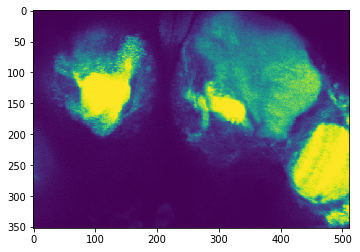

In [186]:
plt.imshow(brains[0][:,:,40])

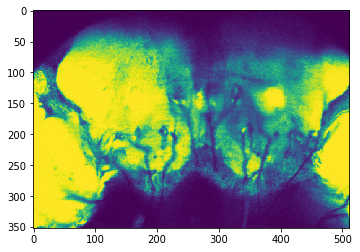

In [187]:
plt.imshow(brains[1][:,:,40])

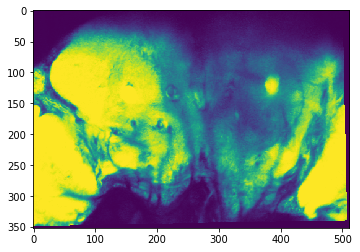

In [199]:
plt.imshow(romt[:,:,40])

In [233]:
t0 = time()
test = ants.apply_transforms(brains[0],
                             brains[1],
                             motCorr['fwdtransforms'])
print(time()-t0)

1.8668429851531982


In [201]:
brain_down[0]

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (88, 128, 67)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [211]:
brain_down0 = ants.resample_image(brains[0], [4,4,4])
brain_down1 = ants.resample_image(brains[1], [4,4,4])

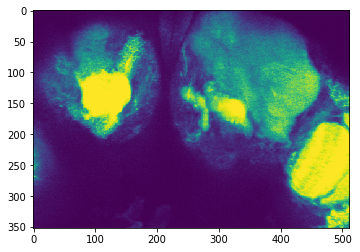

In [229]:
plt.imshow(brains[0][:,:,45])

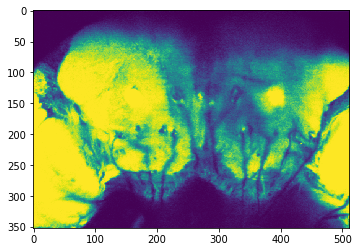

In [230]:
plt.imshow(brains[1][:,:,45])

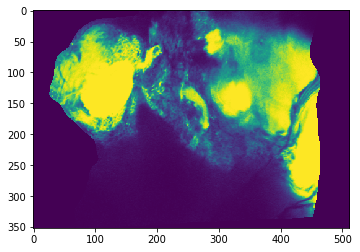

In [234]:
plt.imshow(test[:,:,45])

In [225]:
test

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (352, 512, 267)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

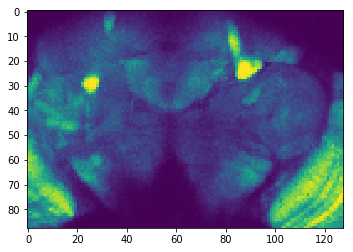

In [216]:
plt.imshow(brain_down0[:,:,30])

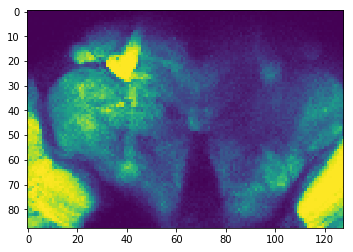

In [217]:
plt.imshow(brain_down1[:,:,30])

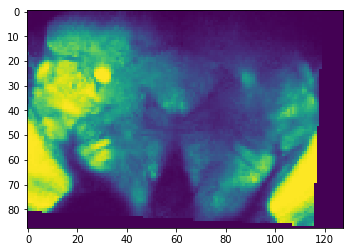

In [215]:
plt.imshow(motCorr_affine['warpedmovout'].numpy()[:,:,30])

In [210]:
test

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (88, 128, 67)
	 Spacing    : (4.0, 4.0, 4.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [192]:
motCorr_affine['fwdtransforms']

['/tmp/tmpyfp31bwn0GenericAffine.mat']

In [193]:
bing = ants.read_transform(motCorr_affine['fwdtransforms'][0])

In [194]:
bing

ANTsTransform
	 Type       : AffineTransform
	 Dimension  : 3
	 Precision  : float

In [200]:
bing.parameters

array([ 1.00494087,  0.0181022 , -0.0392924 , -0.02134383,  1.0021131 ,
       -0.08421071,  0.03763008,  0.08496655,  1.00156999,  3.81589556,
       11.24905205, -4.94389534])

In [197]:
romt = bing.apply_to_image(brains[1], brains[0])

In [198]:
romt

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (352, 512, 267)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [164]:
thing = ants.n4_bias_field_correction(brains[0], shrink_factor=3)

In [156]:
thing

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (352, 512, 267)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

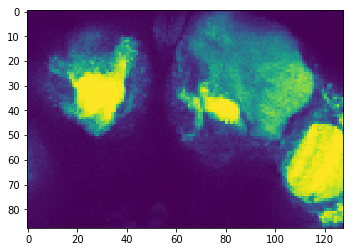

In [110]:
plt.imshow(brain_down[0][:,:,10])

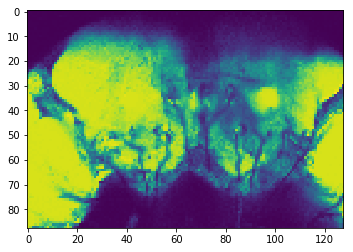

In [111]:
plt.imshow(brain_down[1][:,:,10])

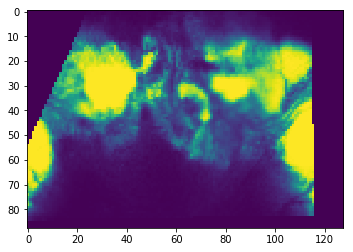

In [146]:
plt.imshow(motCorr_affine['warpedmovout'][:,:,10])

In [34]:
transform[0]

'/tmp/tmpbz78sns71Warp.nii.gz'

In [81]:
test4 = rotate_brain(test4)

In [82]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/0123_this.nii'
ants.image_write(test4, save_file)

In [26]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/down1_cc.nii'
ants.image_write(ants.from_numpy(warps[0]), save_file)

save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/down0_cc.nii'
ants.image_write(down0, save_file)

In [15]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/applied.nii'
ants.image_write(applied, save_file)

In [60]:
warps_r = []

for brain in warps:
    brain_r = rotate_brain(brain)
    warps_r.append(brain_r)

In [63]:
for i, brain in enumerate(warps_r):
    save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/affine_warps/affine_warp' + str(i+1) + '.nii'
    ants.image_write(brain, save_file)

In [21]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/brain_2.nii'
ants.image_write(brains[0], save_file)

In [14]:
brain_files = ['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly1/anatomy/ZSeries-12172018-1322-000.nii']

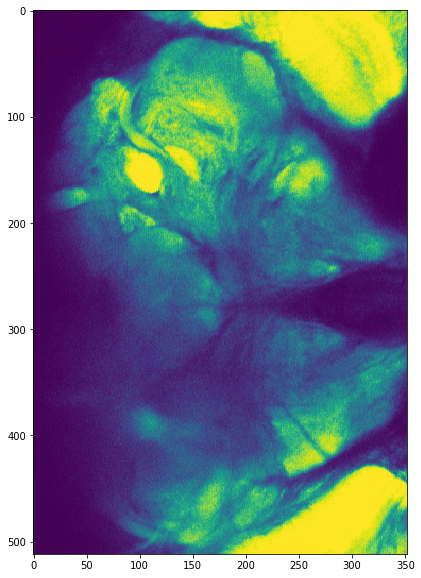

In [44]:
fig = plt.figure(figsize=[10,10])
plt.imshow(brains[1][:,:,100])

In [2]:
anat_f1 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly2/anatomy/ZSeries-12172018-1322-001.nii'
anat_f2 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181127/fly1/anatomy-000.nii'

In [30]:
nib_brain2 = nib.load(anat_f2).get_data()
nib_brain2 = np.swapaxes(nib_brain2, 0, 1)
brain2 = ants.from_numpy(nib_brain2)

In [783]:
import psutil
psutil.virtual_memory()

ModuleNotFoundError: No module named 'psutil'

In [53]:
271/2

135.5

In [68]:
brain1

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (88, 128, 55, 4006)
	 Spacing    : (1.0, 1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

In [69]:
brain2

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (65, 129, 41, 5805)
	 Spacing    : (1.0, 1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

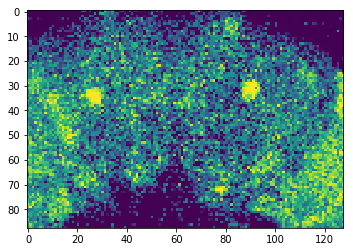

In [65]:
plt.imshow(brain1[:,:,20,0])

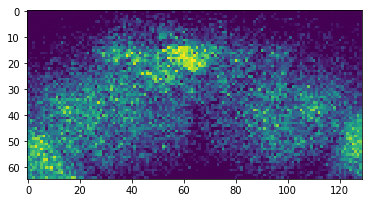

In [66]:
plt.imshow(brain2[:,:,20,0])

In [33]:
t0 = time()
motCorr_slice = ants.registration(brain1, brain2, type_of_transform='SyN')
print(time()-t0)

991.6871283054352


In [43]:
warped = motCorr_slice['warpedmovout'].numpy()
warped = np.swapaxes(warped, 0, 1)
warped = ants.from_numpy(warped)

In [21]:
np.shape(nib_brain)

(260, 516, 201, 1)

In [35]:
np.shape(thing)

(704, 1024, 271, 1)

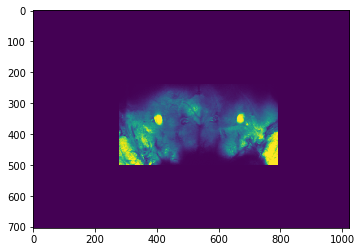

In [40]:
plt.imshow(thing[:,:,100,0])

In [46]:
ants.image_header_info(anat_f1)

{'dimensions': (1024.0, 704.0, 271.0), 'direction': array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]), 'nComponents': 1, 'nDimensions': 3, 'origin': (0.0,
  0.0,
  0.0), 'pixelclass': 'scalar', 'pixeltype': 'short', 'spacing': (0.0007,
  0.0007,
  0.001)}

In [57]:
mi = ants.resample_image(brain1,np.array(brain1.spacing)*2,interp_type=0) # speed up

In [59]:
np.shape(mi)

(352, 512, 136, 1)

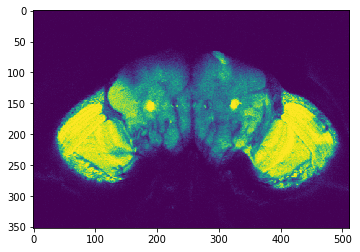

In [60]:
plt.imshow(mi[:,:,50,0])

In [11]:
meanbrain = brain.mean(3)
meanbrain = ants.from_numpy(meanbrain)

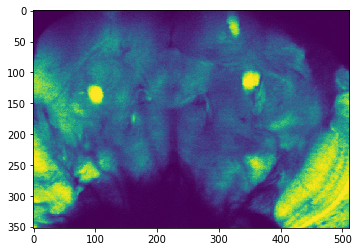

In [8]:
plt.imshow(meanbrain[:,:,100])

In [167]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/meanbrain2.nii'

In [168]:
ants.image_write(meanbrain2, save_file)

In [ ]:
### What about completely scrapping anatomy and just using mean of functional imaging?...
# let's at least try!

In [61]:
func_f1 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly2/TSeries-12172018-1322-001_green.nii'
func_f2 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181127/fly1/TSeries-11272018-1436-000.nii'

In [172]:
brain1 = load_brain(anat_f1)
brain2 = load_brain(anat_f2)

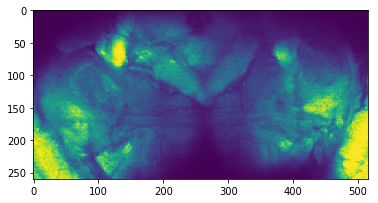

In [176]:
plt.imshow(brain2[:,:,100,0])

In [63]:
nib_brain2 = nib.load(func_f2).get_data()
nib_brain2 = np.swapaxes(nib_brain2, 0, 1)
brain2 = ants.from_numpy(nib_brain2)

In [71]:
meanbrain2 = brain2.mean(3)
meanbrain2 = ants.from_numpy(meanbrain2)

In [ ]:
### load all func brains, get mean brains, affine alignment, average all mean brains
### Then, SyNCC align mean func brains to main mean brain, then average again.
### This becomes my mean brain

In [ ]:
t0 = time()
motCorr = ants.registration(brain1,
                            brain2,
                            type_of_transform='SyNCC',
                            verbose=True,
                            grad_step = 0.2,
                            flow_sigma=3,
                            total_sigma=0,
                            reg_interations=(40,20,0))
print(time()-t0)
warped = motCorr['warpedmovout'].numpy()
warped_fixed = motCorr['warpedfixout'].numpy()

In [111]:
motCorr

{'fwdtransforms': ['/tmp/tmpr0pnb_s61Warp.nii.gz',
  '/tmp/tmpr0pnb_s60GenericAffine.mat'],
 'invtransforms': ['/tmp/tmpr0pnb_s60GenericAffine.mat',
  '/tmp/tmpr0pnb_s61InverseWarp.nii.gz'],
 'warpedfixout': ANTsImage
 	 Pixel Type : float
 	 Components : 1
 	 Dimensions : (65, 129, 41)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'warpedmovout': ANTsImage
 	 Pixel Type : float
 	 Components : 1
 	 Dimensions : (88, 128, 55)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]}

In [170]:
def load_brain(file):
    brain = nib.load(file).get_data()
    brain = np.swapaxes(brain, 0, 1)
    brain = ants.from_numpy(brain)
    return brain

def rotate_brain(brain):
    if type(brain) is not np.ndarray:
        brain = brain.numpy()
    brain = np.swapaxes(brain, 0, 1)
    brain = ants.from_numpy(brain)
    return brain

In [166]:
meanbrain2 = rotate_brain(meanbrain2)

In [154]:
type(warped) == 'numpy.ndarray'

False

In [153]:
str(type(warped))

"<class 'numpy.ndarray'>"

In [105]:
warped = motCorr_slice['warpedmovout'].numpy()
#warped = np.swapaxes(warped, 0, 1)
#warped = ants.from_numpy(warped)

In [95]:
meanbrain1 = meanbrain1.numpy()
meanbrain1 = np.swapaxes(meanbrain1, 0, 1)
meanbrain1 = ants.from_numpy(meanbrain1)

In [ ]:
meanbrain2 = meanbrain2.numpy()
meanbrain2 = np.swapaxes(meanbrain2, 0, 1)
meanbrain2 = ants.from_numpy(meanbrain1)

In [82]:
warped

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (128, 88, 55)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

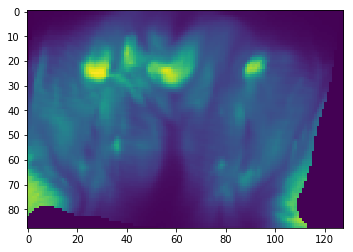

In [89]:
plt.imshow(warped[:,:,29])

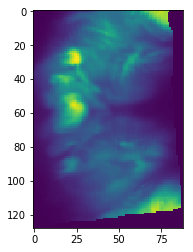

In [160]:
plt.imshow(warped[:,:,29])

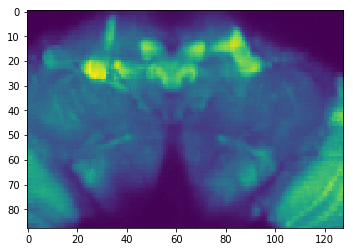

In [137]:
plt.imshow(meanbrain1[:,:,29])

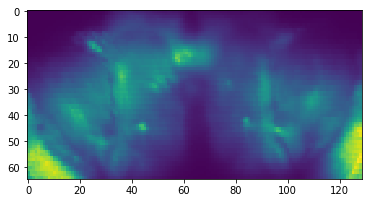

In [131]:
plt.imshow(meanbrain2[:,:,29])

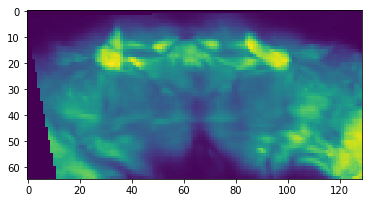

In [140]:
plt.imshow(warped_fixed[:,:,20])